In [49]:
from keras.preprocessing.image import img_to_array,load_img
#from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import os
from collections import Counter
from collections import defaultdict
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
import math

working_dir = "../input"

In [2]:
with open("labels.pkl","rb") as f:
    labels = pkl.load(f)
    
label_dict = labels.to_dict()

In [3]:
train_data_dir = working_dir + "/train_images/"
validation_data_dir = working_dir + "/test_images/"
batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip = True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical') #多分类

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical') #多分类

Found 46650 images belonging to 5 classes.
Found 11661 images belonging to 5 classes.


In [4]:
model = Sequential()
input_shape = (256, 256, 3)
classes = 5

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=  input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(classes))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
samples_per_epoch = 1024
validation_samples = 64
epochs = 10
batch_size = 32

model.fit_generator(
    train_generator,
    steps_per_epoch = samples_per_epoch // batch_size,
    epochs=epochs,
    validation_data= validation_generator,
    validation_steps= validation_samples // batch_size)

model.save_weights('first_image_model.h5')  # always save your weights after training or during training

Epoch 1/10
32/32 [==============================] - 54s 2s/step - loss: 1.5040 - acc: 0.2676 - val_loss: 1.4577 - val_acc: 0.2812
Epoch 2/10
32/32 [==============================] - 55s 2s/step - loss: 1.4894 - acc: 0.2666 - val_loss: 1.4391 - val_acc: 0.3438
Epoch 3/10
32/32 [==============================] - 54s 2s/step - loss: 1.4879 - acc: 0.2783 - val_loss: 1.4450 - val_acc: 0.2656
Epoch 4/10
32/32 [==============================] - 53s 2s/step - loss: 1.5001 - acc: 0.2500 - val_loss: 1.4831 - val_acc: 0.2500
Epoch 5/10
32/32 [==============================] - 54s 2s/step - loss: 1.4893 - acc: 0.2539 - val_loss: 1.4729 - val_acc: 0.2969
Epoch 6/10
32/32 [==============================] - 51s 2s/step - loss: 1.4907 - acc: 0.2588 - val_loss: 1.4226 - val_acc: 0.3594
Epoch 7/10
32/32 [==============================] - 53s 2s/step - loss: 1.4890 - acc: 0.2637 - val_loss: 1.4862 - val_acc: 0.2500
Epoch 8/10
32/32 [==============================] - 54s 2s/step - loss: 1.4722 - acc: 0.26

In [54]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = working_dir + "/train_images2/"
validation_data_dir = working_dir + "/test_images2/"
num_of_class = 5
epochs = 10
batch_size = 32


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    nb_train_samples = len(train_generator.filenames)  
    num_classes = len(train_generator.class_indices)     
    predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

    bottleneck_features_train = model.predict_generator(
        train_generator,predict_size_train)
    
    #nb_train_samples // batch_size
    np.save('bottleneck_features_train.npy',bottleneck_features_train)

    valid_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size= batch_size,
        class_mode=None,
        shuffle=False)
     
    nb_validation_samples = len(valid_generator.filenames)  
    num_classes = len(valid_generator.class_indices)
    predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
    
    
    bottleneck_features_validation = model.predict_generator(
        valid_generator, predict_size_validation)
    
    # nb_validation_samples // batch_size
    np.save('bottleneck_features_validation.npy',bottleneck_features_validation)

save_bottlebeck_features()

Found 1764 images belonging to 5 classes.


In [55]:
def get_train_and_labels(train_data_dir,feature_file):
    datagen_top = ImageDataGenerator(rescale=1./255)  
    generator_top = datagen_top.flow_from_directory(  
             train_data_dir,  
             target_size=(img_width, img_height),  
             batch_size = batch_size,  
             class_mode='categorical',  
             shuffle=False)
    
    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)
    
    #load the bottleneck features saved earlier  
    train_data = None
    train_data = np.load(feature_file)  
   
    # get the class lebels for the training data, in the original order  
    train_labels = generator_top.classes
    print(Counter(train_labels))
    # convert the training labels to categorical vectors  
    train_labels = to_categorical(train_labels, num_classes=num_classes) 
    
    return train_data, train_labels

    
X_train,y_train = get_train_and_labels(train_data_dir,'bottleneck_features_train.npy')
X_test,y_test = get_train_and_labels(validation_data_dir,'bottleneck_features_validation.npy')

Found 3254 images belonging to 5 classes.
Counter({4: 930, 1: 840, 3: 640, 2: 530, 0: 314})
Found 1764 images belonging to 5 classes.
Counter({1: 420, 4: 370, 3: 365, 2: 315, 0: 294})


In [57]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((3254, 7, 7, 512), (3254, 5), (1764, 7, 7, 512), (1764, 5))

In [64]:
model = Sequential()
model.add(Flatten(input_shape= X_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_class, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_test,y_test))

model.save_weights(top_model_weights_path)

Train on 3254 samples, validate on 1764 samples
Epoch 1/10
3254/3254 [==============================] - 8s 2ms/step - loss: 4.3197 - acc: 0.2720 - val_loss: 1.6752 - val_acc: 0.2585
Epoch 2/10
3254/3254 [==============================] - 6s 2ms/step - loss: 1.6406 - acc: 0.2766 - val_loss: 1.7238 - val_acc: 0.2568
Epoch 3/10
3254/3254 [==============================] - 6s 2ms/step - loss: 1.5659 - acc: 0.3104 - val_loss: 1.7180 - val_acc: 0.2687
Epoch 4/10
3254/3254 [==============================] - 6s 2ms/step - loss: 1.5544 - acc: 0.3258 - val_loss: 1.5966 - val_acc: 0.2806
Epoch 5/10
3254/3254 [==============================] - 6s 2ms/step - loss: 1.5276 - acc: 0.3368 - val_loss: 1.6242 - val_acc: 0.2766
Epoch 6/10
3254/3254 [==============================] - 6s 2ms/step - loss: 1.4922 - acc: 0.3516 - val_loss: 1.6657 - val_acc: 0.2846
Epoch 7/10
3254/3254 [==============================] - 6s 2ms/step - loss: 1.4458 - acc: 0.3740 - val_loss: 1.7821 - val_acc: 0.2585
Epoch 8/10
325

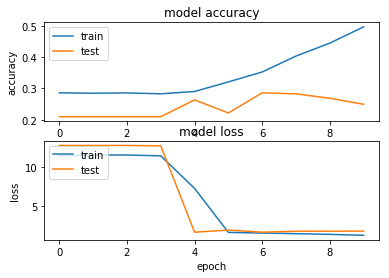

In [61]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  